<h2> Sentiment Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Importing Natural Language Toolkit
import nltk
#Importing String for list of punctuations
import string
#Importing module for text corrections
import textblob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import roc_Curve, auc

#Importing stopwords list
from nltk.corpus import stopwords
#Importing Lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
#Importing Tokenizer
from nltk.tokenize import RegexpTokenizer
#Importing TextBlob
from textblob import TextBlob

import os 

In [2]:
!ls

 Images				   requirements.txt
'ML-MAJOR-MAR-ML03B16 (1).ipynb'   Womens_Clothing_E_Commerce_Reviews.csv
 README.md


In [3]:
#reading data
data = pd.read_csv('Womens_Clothing_E_Commerce_Reviews.csv', sep =',')
# data = data[['Age','Title','Review_Text','Rating','Recommended_IND','Pos_Feedback_count','Division_Name','Department_Name','Class_Name','Clothing_ID']]
#droping unnamed as we have automated index and Clothing ID
data.drop(['Unnamed: 0'], axis = 1, inplace = True)

#renaming for ease
data.rename(columns = {'Review Text':'Review_Text', 'Recommended IND':'Recommended_IND', 'Positive Feedback Count': 'Pos_Feedback_count',
                       'Division Name':'Division_Name', 'Department Name':'Department_Name','Class Name':'Class_Name','Clothing ID':'Clothing_ID'}, inplace = True)

#dropping null Review Text
data.dropna(subset = ['Review_Text'], axis = 0, inplace = True)

data.reset_index(inplace = True, drop = True)

In [4]:
data.describe()

,Clothing_ID,Age,Rating,Recommended_IND,Pos_Feedback_count
count,22641.000000,22641.000000,22641.000000,22641.000000,22641.000000
mean,919.332362,43.280376,4.183561,0.818868,2.630582
std,202.266874,12.326980,1.115762,0.385136,5.786164
min,1.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


In [5]:
data.dtypes

Clothing_ID            int64
Age                    int64
Title                 object
Review_Text           object
Rating                 int64
Recommended_IND        int64
Pos_Feedback_count     int64
Division_Name         object
Department_Name       object
Class_Name            object
dtype: object

In [6]:
#count of word in each sentence of Review text
data['word_count'] = data['Review_Text'].apply(lambda x: len(str(x).split(" ")))
data[['Review_Text','word_count']].head(15)

,Review_Text,word_count
0,Absolutely wonderful - silky and sexy and comf...,8
1,Love this dress! it's sooo pretty. i happene...,67
2,I had such high hopes for this dress and reall...,98
3,"I love, love, love this jumpsuit. it's fun, fl...",22
4,This shirt is very flattering to all due to th...,36
5,"I love tracy reese dresses, but this one is no...",98
6,I aded this in my basket at hte last mintue to...,101
7,"I ordered this in carbon for store pick up, an...",97
8,I love this dress. i usually get an xs but it ...,34
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",72


<AxesSubplot:xlabel='Age'>

<Figure size 1500x1500 with 0 Axes>

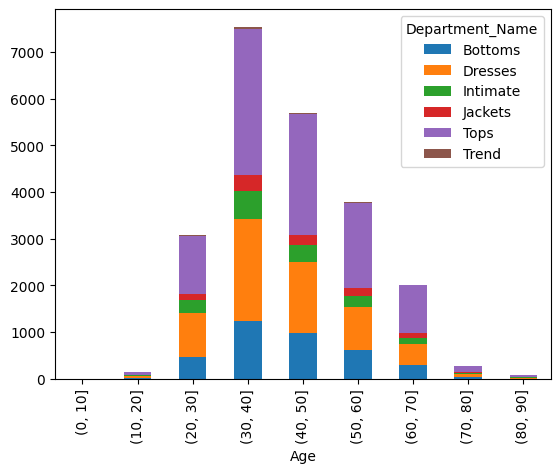

In [7]:
plt.figure(figsize=(15,15))
data.groupby(['Department_Name', pd.cut(data['Age'], np.arange(0,100,10))])\
       .size()\
       .unstack(0)\
       .plot.bar(stacked=True)

In [8]:
#New column Rating Class

set1 = []

for i in range(0,22641):
    if data.Rating[i]>3:
        set1.append('Good')
    else:
        set1.append('Bad')
data['Rating_Class']= set1

#good = 1 bad = 0
data['Binary_Rating'] = 0
data.loc[data.Rating_Class=='Good',['Binary_Rating']] = 1
data.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Pos_Feedback_count,Division_Name,Department_Name,Class_Name,word_count,Rating_Class,Binary_Rating
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8,Good,1
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,67,Good,1
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98,Bad,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22,Good,1
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36,Good,1


5    12540
4     4908
3     2823
2     1549
1      821
Name: Rating, dtype: int64

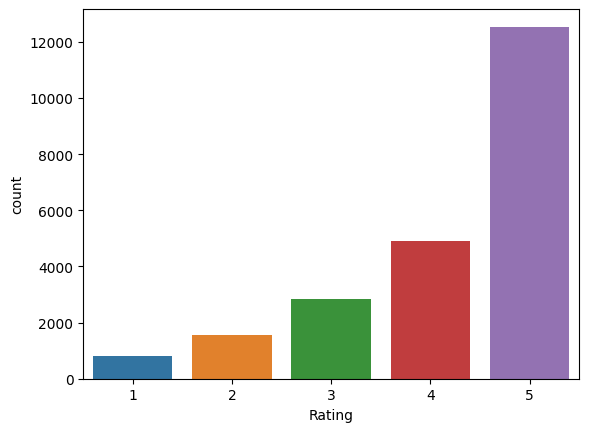

In [9]:
sns.countplot(x = 'Rating', data = data)
data.Rating.value_counts()

Good    17448
Bad      5193
Name: Rating_Class, dtype: int64

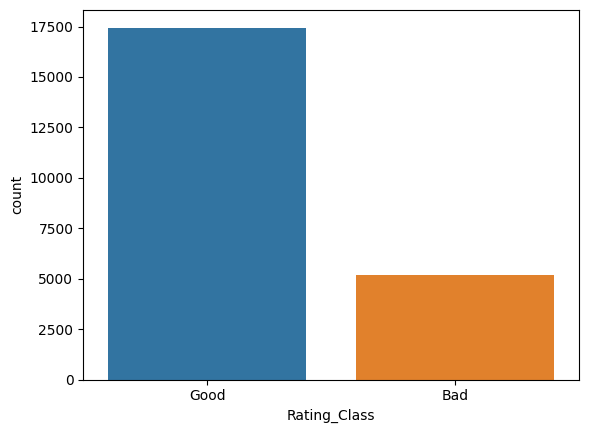

In [10]:
sns.countplot(x="Rating_Class", data=data)
data.Rating_Class.value_counts()

In [11]:
# Clothing ID's with highest review counts-
data.groupby(['Clothing_ID'])['Clothing_ID'].agg(counts = 'count').reset_index().sort_values(by = 'counts', ascending = False)

,Clothing_ID,counts
1053,1078,987
838,862,778
1069,1094,735
1056,1081,561
848,872,519
...,...,...
463,483,1
464,484,1
465,485,1
467,487,1


In [18]:
#lets categorise the data on the basis of ages that is into 18-25,25-32,32-39 and so on
bins = [18, 25, 32, 39, 46, 53, 60, 67, 74, 81, 88, 95, 102]
names = ['18-25', '25-32', '32-39', '39-47', '47-53', '53-60', '60-67', '67-74', '74-81', '81-88', '88-95','95-102']
data["Age_Range"] = pd.cut(data.Age, bins , labels = names)



age_a = data[['Age_Range','Rating_Class']]
pos_feed = []
neg_feed = []
for i in range(0,22641):
    if age_a.Rating_Class[i] == 'Good':
        pos_feed.append(int(1))
        neg_feed.append(int(0))
    else:
        pos_feed.append(int(0))
        neg_feed.append(int(1))
age_a['Positive_Feedbacks'] = pos_feed
age_a['Negative_Feedbacks'] = neg_feed

age_a_table = age_a.groupby('Age_Range').sum()
age_a_table



,Positive_Feedbacks,Negative_Feedbacks
Age_Range,,
18-25,953,230
25-32,2360,817
32-39,4429,1392
39-47,3241,1038
47-53,2583,768
53-60,1960,482
60-67,1352,322
67-74,409,110
74-81,77,21


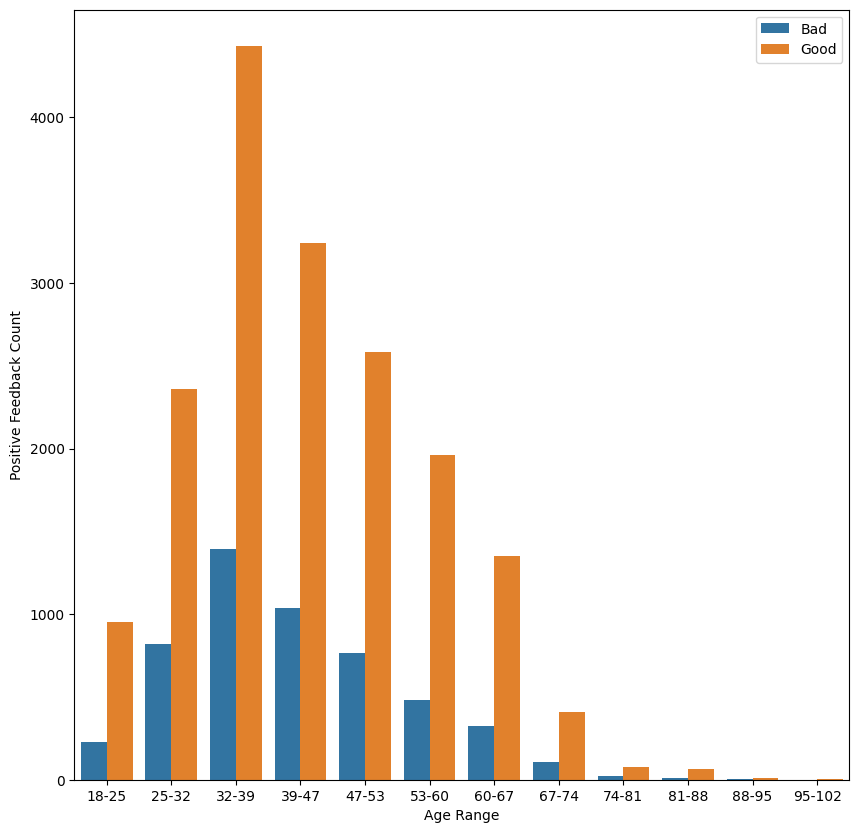

In [19]:
plt.rcParams['figure.figsize'] = (10, 10)
ax = sns.countplot(x = 'Age_Range', hue = 'Positive_Feedbacks', data = age_a, dodge = True)

ax.set(xlabel = 'Age Range', ylabel = 'Positive Feedback Count')
ax.legend(['Bad', 'Good'])

[Text(0.5, 0, 'Rating Class')]

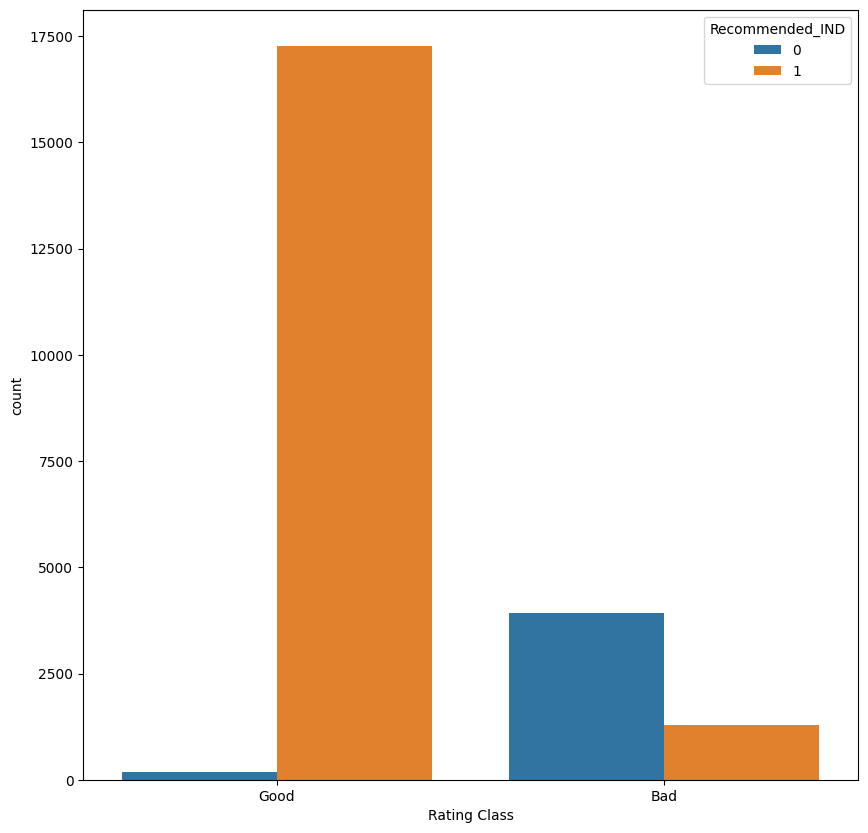

In [20]:
ax = sns.countplot(x = 'Rating_Class', hue = 'Recommended_IND', data = data)
ax.set(xlabel = 'Rating Class')

In [21]:
#dropping Age_Range as it was just for some analysis
data.drop(['Age_Range'],axis = 1, inplace = True)

<h5> Handling Text data

 **Lowercasing**

In [22]:
data['Edited'] = data['Review_Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#for Title column
data.Title[data.Title.isnull()] = ''
data['EditedTitle'] = data['Title'].apply(lambda x: " ".join(x.lower() for x in x.split()))

data['Edited'].head()

0    absolutely wonderful - silky and sexy and comf...
1    love this dress! it's sooo pretty. i happened ...
2    i had such high hopes for this dress and reall...
3    i love, love, love this jumpsuit. it's fun, fl...
4    this shirt is very flattering to all due to th...
Name: Edited, dtype: object

**Removing Punctuation**

In [23]:
data['Edited'] = data['Edited'].str.replace('[^\w\s]','')
data['EditedTitle'] = data['EditedTitle'].str.replace('[^\w\s]','')

data['Edited'].head()

0    absolutely wonderful  silky and sexy and comfo...
1    love this dress its sooo pretty i happened to ...
2    i had such high hopes for this dress and reall...
3    i love love love this jumpsuit its fun flirty ...
4    this shirt is very flattering to all due to th...
Name: Edited, dtype: object

**Removing Stop Words**


In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siddharthm10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
data['Edited'] = data['Edited'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['EditedTitle'] = data['EditedTitle'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

data['Edited'].head()

0          absolutely wonderful silky sexy comfortable
1    love dress sooo pretty happened find store im ...
2    high hopes dress really wanted work initially ...
3    love love love jumpsuit fun flirty fabulous ev...
4    shirt flattering due adjustable front tie perf...
Name: Edited, dtype: object

**Removing Commonly Occuring words** in the text as they wont help us in making the model any better

In [26]:
#These are the 10 most frequent words , so we'll remove these
freq = pd.Series(' '.join(data['Edited']).split()).value_counts()[:10]
freq1 = pd.Series(' '.join(data['EditedTitle']).split()).value_counts()[:10]

freq = list(freq.index)
freq1 = list(freq1.index)

data['Edited'] = data['Edited'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['EditedTitle'] = data['EditedTitle'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

data['Edited'].head()

0          absolutely wonderful silky sexy comfortable
1    sooo pretty happened find store glad bc never ...
2    high hopes really wanted work initially ordere...
3    jumpsuit fun flirty fabulous every time get no...
4    shirt flattering due adjustable front tie perf...
Name: Edited, dtype: object

**Rare Words Removal**: As they wont help us as it is very rare if the users will use those words in future

In [27]:
#10 least frequent words
freq = pd.Series(' '.join(data['Edited']).split()).value_counts()[-10:]
freq1 = pd.Series(' '.join(data['EditedTitle']).split()).value_counts()[-10:]

freq = list(freq.index)
freq1 = list(freq1.index)

data['Edited'] = data['Edited'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['EditedTitle'] = data['EditedTitle'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

data['Edited'].head(10)

0          absolutely wonderful silky sexy comfortable
1    sooo pretty happened find store glad bc never ...
2    high hopes really wanted work initially ordere...
3    jumpsuit fun flirty fabulous every time get no...
4    shirt flattering due adjustable front tie perf...
5    tracy reese dresses one petite 5 feet tall usu...
6    aded basket hte last mintue see look person st...
7    ordered carbon store pick ton stuff always try...
8    usually get xs runs little snug bust ordered f...
9    55 125 lbs ordered petite make sure length was...
Name: Edited, dtype: object

**Tokenize**


In [28]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/siddharthm10/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/siddharthm10/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
for x in range(0,22641):
    data['Edited'][x] = TextBlob(data['Edited'][x]).words
for x in range(0,22641):
    data['EditedTitle'][x] = TextBlob(data['EditedTitle'][x]).words
data.Edited.head()

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [sooo, pretty, happened, find, store, glad, bc...
2    [high, hopes, really, wanted, work, initially,...
3    [jumpsuit, fun, flirty, fabulous, every, time,...
4    [shirt, flattering, due, adjustable, front, ti...
Name: Edited, dtype: object

**Lemmatization**

In [30]:
lem = WordNetLemmatizer()

data['Edited'] = data['Edited'].apply(lambda x: ([lem.lemmatize(word, pos = 'n') for word in x]))
data['Edited'] = data['Edited'].apply(lambda x: ([lem.lemmatize(word, pos = 'r') for word in x]))
data['Edited'] = data['Edited'].apply(lambda x: ([lem.lemmatize(word, pos = 'v') for word in x]))
data['Edited'] = data['Edited'].apply(lambda x: ([lem.lemmatize(word, pos = 'a') for word in x]))

data['EditedTitle'] = data['EditedTitle'].apply(lambda x: ([lem.lemmatize(word, pos = 'n') for word in x]))
data['EditedTitle'] = data['EditedTitle'].apply(lambda x: ([lem.lemmatize(word, pos = 'r') for word in x]))
data['EditedTitle'] = data['EditedTitle'].apply(lambda x: ([lem.lemmatize(word, pos = 'v') for word in x]))
data['EditedTitle'] = data['EditedTitle'].apply(lambda x: ([lem.lemmatize(word, pos = 'a') for word in x]))

data.Edited.head()

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [sooo, pretty, happen, find, store, glad, bc, ...
2    [high, hope, really, want, work, initially, or...
3    [jumpsuit, fun, flirty, fabulous, every, time,...
4    [shirt, flat, due, adjustable, front, tie, per...
Name: Edited, dtype: object

**Removing words without meaning** as spell check was taking too much time

In [31]:
from nltk.corpus import wordnet
for i in range(0,22641):
    only_recognized_words = []
    for t in data.Edited[i]:
        if wordnet.synsets(t):
            if t.isalpha():
                only_recognized_words.append(t)
    data.Edited[i] = only_recognized_words 
    
for i in range(0,22641):
    only_recognized_words = []
    for t in data.EditedTitle[i]:
        if wordnet.synsets(t):
            if t.isalpha():
                only_recognized_words.append(t)
    data.EditedTitle[i] = only_recognized_words 
    
data.Edited.head()

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [pretty, happen, find, store, glad, bc, never,...
2    [high, hope, really, want, work, initially, or...
3    [jumpsuit, fun, fabulous, every, time, get, no...
4    [shirt, flat, due, adjustable, front, tie, per...
Name: Edited, dtype: object

In [32]:
#joining data for model application
for i in range(0,22641):
    data.Edited[i] = ' '.join(data.Edited[i])
    data.EditedTitle[i] = ' '.join(data.EditedTitle[i])    

In [33]:
f_data = data[['EditedTitle','Edited','Recommended_IND','Rating_Class','Binary_Rating']]
#Binary Rating has to be predicted on the basis of EditedTitle, Edited and Recommended_IND - f_data - contains all values
f_data.head()

,EditedTitle,Edited,Recommended_IND,Rating_Class,Binary_Rating
0,,absolutely wonderful silky sexy comfortable,1,Good,1
1,,pretty happen find store glad bc never order o...,1,Good,1
2,major design flaw,high hope really want work initially order pet...,0,Bad,0
3,favorite buy,jumpsuit fun fabulous every time get nothing c...,1,Good,1
4,flat shirt,shirt flat due adjustable front tie perfect le...,1,Good,1


In [39]:
#wordCLoud
from wordcloud import WordCloud
good_words = ' '.join([text for text in f_data[f_data.Rating_Class == 'Good']['Edited']])
wordcloud = WordCloud(width = 600, height = 400, random_state = 21, max_font_size = 100).generate(good_words)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()


ValueError: Only supported for TrueType fonts

In [ ]:
from wordcloud import WordCloud
bad_words = ' '.join([text for text in f_data[f_data.Rating_Class == 'Bad']['Edited']])
wordcloud = WordCloud(width = 600, height = 400, random_state = 21,background_color="white", max_font_size = 100).generate(bad_words)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [40]:
#Text Polarity
f_data['Polarity'] = f_data['Edited'].apply(lambda x: TextBlob(x).sentiment.polarity)
f_data.head(5)

,EditedTitle,Edited,Recommended_IND,Rating_Class,Binary_Rating,Polarity
0,,absolutely wonderful silky sexy comfortable,1,Good,1,0.633333
1,,pretty happen find store glad bc never order o...,1,Good,1,0.228125
2,major design flaw,high hope really want work initially order pet...,0,Bad,0,0.045530
3,favorite buy,jumpsuit fun fabulous every time get nothing c...,1,Good,1,0.350000
4,flat shirt,shirt flat due adjustable front tie perfect le...,1,Good,1,0.283333


<AxesSubplot:ylabel='Frequency'>

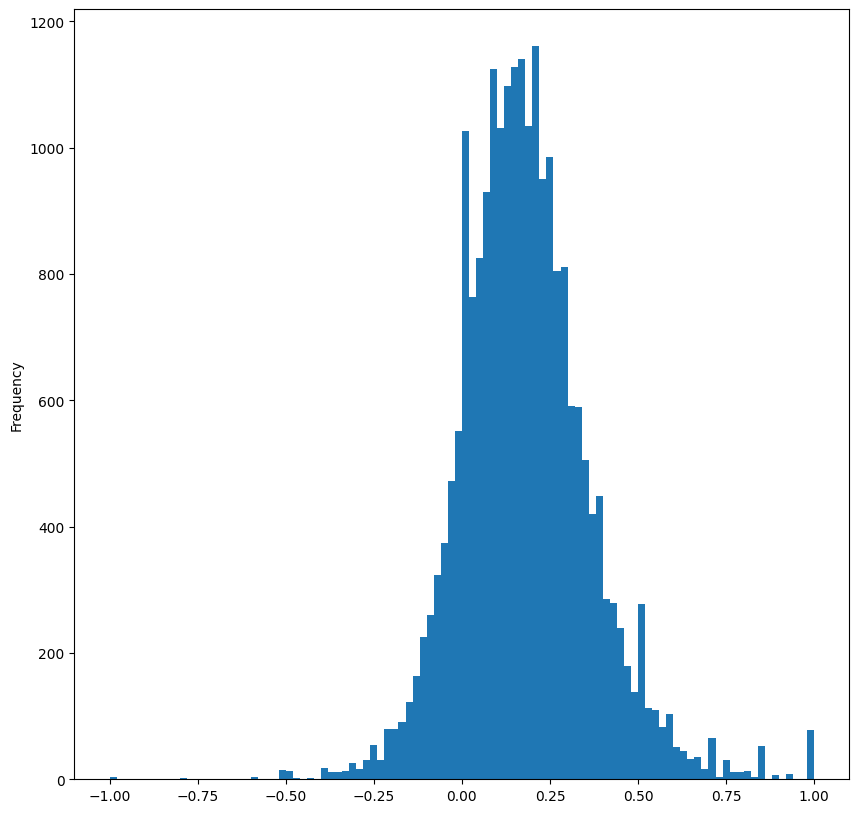

In [41]:
f_data['Polarity'].plot(kind='hist', bins=100)

<h4>Train Test split for modeling

In [42]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter


In [43]:
x_train1, x_test1 = train_test_split(f_data[['Edited', 'EditedTitle', 'Recommended_IND']], test_size = 0.8)

In [44]:
#Vectorization
vectorizer = TfidfVectorizer(min_df = 10, ngram_range=(1,3))
vectorizer.fit_transform(x_train1['Edited'])
vectorizer.fit_transform(x_train1['EditedTitle'])

X1 = vectorizer.transform(f_data['Edited'].values)
X2 = vectorizer.transform(f_data['EditedTitle'].values)

print('Shape of the vectorizer after one hot encoding',X1.shape)
print('Shape of the vectorizer after one hot encoding',X2.shape)

Shape of the vectorizer after one hot encoding (22641, 165)
Shape of the vectorizer after one hot encoding (22641, 165)


In [45]:
X1

<22641x165 sparse matrix of type '<class 'numpy.float64'>'
	with 215805 stored elements in Compressed Sparse Row format>

In [46]:
import scipy
from scipy.sparse import hstack
Final_Data = hstack((X1, X2, scipy.sparse.csr.csr_matrix(data['Recommended_IND']).T))

In [47]:
X_tr,X_test,Y_tr,Y_test = train_test_split(Final_Data, f_data['Binary_Rating'], test_size = 0.2)

In [48]:
results = []
names = []


<h3> KNN

In [49]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(n_neighbors=7)
clf = knn.fit(X_tr, Y_tr)

# Input Data to predict their classes of the given categories
predicted = clf.predict(X_test)

In [50]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
predicted = clf.predict(X_test)
predicted_trn = clf.predict(X_tr)
print('Train Accuracy', accuracy_score(Y_tr, predicted_trn))
print('Test Accuracy', accuracy_score(Y_test, predicted))
print( classification_report(Y_test, predicted))

Train Accuracy 0.9375
Test Accuracy 0.9326562155001104
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      1070
           1       0.93      0.98      0.96      3459

    accuracy                           0.93      4529
   macro avg       0.93      0.88      0.90      4529
weighted avg       0.93      0.93      0.93      4529



[[ 820  250]
 [  55 3404]]


<AxesSubplot:>

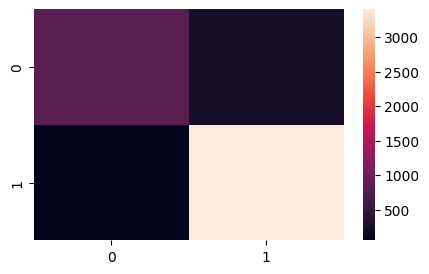

In [51]:
cm = confusion_matrix(Y_test, predicted)
print(cm)
plt.figure(figsize = (5,3))
sns.heatmap(cm)

In [52]:
results.append(accuracy_score(Y_test, predicted))
names.append('KNN')

<h3> Naive Bayes

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
C = [10**x for x in range(-4,4)]
tuned_parameters = [{'alpha': C}]
model = GridSearchCV(BernoulliNB(binarize = 0.0, class_prior=None, fit_prior=True),tuned_parameters,scoring = 'f1_macro', return_train_score = True)
model.fit(X_tr, Y_tr)
cv_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score']

In [54]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
predicted = model.predict(X_test)
predicted_trn = model.predict(X_tr)
print('Train Accuracy', accuracy_score(Y_tr, predicted_trn))
print('Test Accuracy', accuracy_score(Y_test, predicted))
print( classification_report(Y_test, predicted))

Train Accuracy 0.9268992932862191
Test Accuracy 0.9253698388165158
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1070
           1       0.94      0.96      0.95      3459

    accuracy                           0.93      4529
   macro avg       0.91      0.88      0.89      4529
weighted avg       0.92      0.93      0.92      4529



[[ 858  212]
 [ 126 3333]]


<AxesSubplot:>

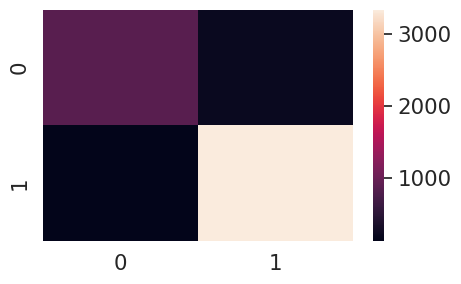

In [55]:
cm = confusion_matrix(Y_test, predicted)
print(cm)
plt.figure(figsize=(5,3))
sns.set(font_scale = 1.4)
sns.heatmap(cm)

In [56]:
results.append(accuracy_score(Y_test,predicted))
names.append('BernouliNB')

<h3> Linear SVM

In [57]:
alpha1 = [10**x for x in range(-4,4)]
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'alpha':alpha1}]
model = GridSearchCV(SGDClassifier(penalty='l1'), tuned_parameters, scoring='roc_auc', return_train_score = True)
model.fit(X_tr, Y_tr)
cv_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score']

In [58]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
predicted = model.predict(X_test)
predicted_trn = model.predict(X_tr)
print('Train Accuracy', accuracy_score(Y_tr, predicted_trn))
print('Test Accuracy', accuracy_score(Y_test, predicted))
print( classification_report(Y_test, predicted))

Train Accuracy 0.9361196996466431
Test Accuracy 0.9342018105542063
              precision    recall  f1-score   support

           0       0.95      0.76      0.84      1070
           1       0.93      0.99      0.96      3459

    accuracy                           0.93      4529
   macro avg       0.94      0.87      0.90      4529
weighted avg       0.94      0.93      0.93      4529



[[ 812  258]
 [  40 3419]]


<AxesSubplot:>

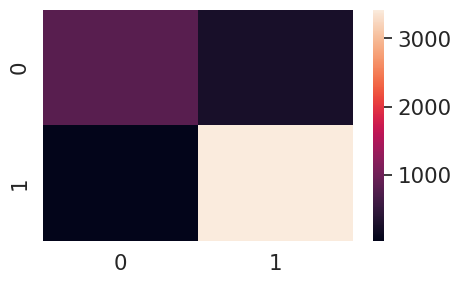

In [59]:
cm = confusion_matrix(Y_test, predicted)
print(cm)
plt.figure(figsize = (5,3))
sns.heatmap(cm)

In [60]:
results.append(accuracy_score(Y_test, predicted))
names.append('Linear SVM')

<H6> Analysis

Since a Naive Bayes text classifier is based on the Bayes's Theorem, which helps us compute the conditional probabilities of occurrence of two events based on the probabilities of occurrence of each individual event, encoding those probabilities is extremely useful.

We have also trained other models like  <br> 
1. Naive Bayes
2. KNN Classification
3. Linear SVM


Also we have made the confusion matrix and the classification report for each of the mentioned models used for prediction

In [61]:
print('Name','Accuracy')
for i in range(0,3):
    print(names[i],results[i])

Name Accuracy
KNN 0.9326562155001104
BernouliNB 0.9253698388165158
Linear SVM 0.9342018105542063


<h6> Result
    

Hence, we can now predict the Rating, whether its 'Good' or 'Bad' on the basis of these models.  
As you saw the confusion matrix and classification report for each model.
Here, we can plot the box plot of the results from different models while setting the scoring to 'accuracy'.  


ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

Thus what we saw was KNN 10 fold, svm and BernouliNB have same accuracy that is around 93% whereas decision tree show a little less accuracy.  
Thus to predict Rating Class on the basis of Review Text we should use one of the three:
1. KNN
2. BernouliNB
3. SVM